In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install emoji
!pip install spacy
!python -m spacy download ru_core_news_sm
!pip install pymorphy2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 59.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 48.2 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=b1bfd87bf1472e781e5c3ba6b3249062f638d224821cb35194acd5cac4da4a

In [ ]:
import emoji
import pymorphy2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import spacy
from nltk.tokenize import word_tokenize
from collections import Counter
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
import torch
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud

Объединяем файлы

In [ ]:
"""`files = ['dataset1.xlsx', 'dataset2.xlsx', 'dataset3.xlsx', 'dataset4.xlsx']

dfs = [pd.read_excel(file) for file in files]
combined_df = pd.concat(dfs, ignore_index=True)

combined_df.to_excel('data_anime.xlsx', index=False)"""

In [ ]:
df = '/content/drive/MyDrive/Colab Notebooks/data_anime.xlsx'
df = pd.read_excel(df)

df.head()

,Anime,Rate,Text
0,Нежный укус / Amagami SS,Нейтральный,"после первой арки несколько разочаровался, ожи..."
1,Легенда о легендарных героях / Densetsu no Yuu...,Положительный,"Концовка какая-то мутная, ничего не понял. Над..."
2,Мобильный воин Гандам: Единорог / Kidou Senshi...,Положительный,"Что тут сказать? Никакого сравнени я с Seed, х..."
3,Невиданный цветок / Ano Hi Mita Hana no Namae ...,Положительный,Только что досмотрел и меня переполняют эмоции...
4,Принцесса-медуза / Kuragehime,Положительный,"И правда не оторваться. Но, по-моему, то, что ..."


In [ ]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73216 entries, 0 to 73215
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Anime   73216 non-null  object
 1   Rate    73216 non-null  object
 2   Text    73215 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


(73216, 3)

In [ ]:
#проверяем число пропусков
sum(df['Rate'].isna())

0

In [ ]:
sum(df['Text'].isna())

1

In [ ]:
sum(df['Anime'].isna())

0

In [ ]:
# удаление строк с пропусками
df = df.dropna(subset=['Text'])

# удаление лишних пробелов
df['Text'] = df['Text'].str.strip()

# удаление дубликатов
df = df.drop_duplicates(subset=['Text'])

In [ ]:
df.shape

(73165, 3)

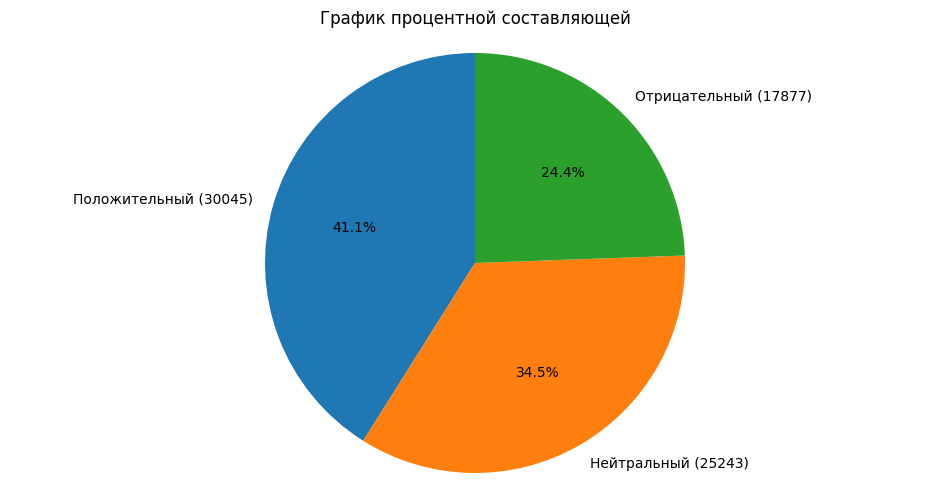

In [ ]:
# подсчёт количества категорий
class_counts = df['Rate'].value_counts()


plt.figure(figsize=(12, 6))
plt.pie(class_counts, labels=[f'{label} ({count})' for label, count in zip(class_counts.index, class_counts)], autopct='%1.1f%%', startangle=90)
plt.title('График процентной составляющей')
plt.axis('equal')

plt.show()

Предобработка


In [ ]:
nltk.download('punkt')
nlp = spacy.load("ru_core_news_sm")
morph = pymorphy2.MorphAnalyzer()

# загрузка кастомных словарей
def load_anime_dict(file_path):
    anime_dict = {}
    with open('/content/drive/MyDrive/Colab Notebooks/anime_dict.txt', 'r', encoding='utf-8') as file:
        for line in file:
            key, value = line.strip().split(':')
            anime_dict[key] = value
    return anime_dict

def load_swear_words(file_path):
    with open('/content/drive/MyDrive/Colab Notebooks/swear_words.txt', 'r', encoding='utf-8') as file:
        swear_words = file.read().splitlines()
    return swear_words


def remove_hyphens_from_numbers(text):
    return re.sub(r'(\d+)-(\w+)', r'\1\2', text)

def reduce_repeated_characters(text):
    return re.sub(r'(.)\1+', r'\1', text)

def replace_anime_terms(text, dictionary):
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in dictionary.keys()) + r')\b', re.IGNORECASE)
    return pattern.sub(lambda x: dictionary[x.group().lower()], text)

def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

def remove_smilies(text):
    smilies_pattern = r'(:\)|:\(|:\||:D|XD|:P|;P|:O|:3|:S|>.<|:-\)|:-\(|:-D|:-P|;\)|\^\^|T_T|>_<|:-o|\(\( |=\\|O_o|o_O|;_;|:-\|)'
    return re.sub(smilies_pattern, '', text)

def remove_mentions(text):
    mentions_pattern = r'@\w+'
    return re.sub(mentions_pattern, '', text)

def remove_urls(text):
    urls_pattern = r'http\S+|www\.\S+|i\d+\.\S+'
    return re.sub(urls_pattern, '', text)

def remove_interjections(text):
    interjections_pattern = r'\b(м|кхм|хм|мм|вуху|мр|фу|ух|вау|вай|бвух|бр|бац|эк|хех|эх|эм|увы|ох|ах|ой|ы|гы|хе)\b'
    return re.sub(interjections_pattern, '', text, flags=re.IGNORECASE)

def remove_acronyms_and_specific_words(text):
    specific_words_pattern = r'\b(tldr|laitqwerty)\b'
    return re.sub(specific_words_pattern, '', text, flags=re.IGNORECASE)

def remove_kanji(text):
    kanji_pattern = r'[一-龯ぁ-ゔァ-ヴー々〆〤]'
    return re.sub(kanji_pattern, '', text)

def remove_abbreviations(text):
    abbreviations_pattern = r'\b(P\.S\.)\b'
    return re.sub(abbreviations_pattern, '', text, flags=re.IGNORECASE)

def remove_swear_words(text, swear_words):
    pattern = r'\b(' + '|'.join(swear_words) + r')\b'
    return re.sub(pattern, '', text, flags=re.IGNORECASE)

def remove_censored_swear_words(text):
    pattern = r'\b\w*\*+\w*\b'
    return re.sub(pattern, '', text, flags=re.IGNORECASE)

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [morph.parse(token)[0].normal_form for token in tokens]
    return ' '.join(lemmatized_tokens)

def remove_stopwords(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop]
    return ' '.join(tokens)


def preprocess_text(text, anime_dict, swear_words):
    text = replace_anime_terms(text, anime_dict)
    text = remove_swear_words(text, swear_words)
    text = remove_censored_swear_words(text)
    text = remove_hyphens_from_numbers(text)
    text = re.sub(r'\bх\d\b', '', text)
    text = re.sub(r'\b\d{1,4}-(?:го|ое|ая|я|ые|е)\b|\b\d{1,4}(?:го|ое|ая|я|ые|е)\b', '', text)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^а-яёА-ЯЁ\s]', ' ', text)
    text = reduce_repeated_characters(text)
    text = remove_emojis(text)
    text = remove_smilies(text)
    text = remove_mentions(text)
    text = remove_urls(text)
    text = remove_interjections(text)
    text = remove_acronyms_and_specific_words(text)
    text = remove_kanji(text)
    text = remove_abbreviations(text)


    text = lemmatize_text(text)
    text = remove_stopwords(text)

    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
preprocess_column = lambda x: preprocess_text(str(x), anime_dict, swear_words)

Предобрабатываем и сохраняем данные частями

In [ ]:
chunk_size = len(df) // 20
chunks = [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

if len(chunks) > 10:
    chunks[-2] = pd.concat([chunks[-2], chunks[-1]])
    chunks = chunks[:-1]

processed_chunks = []

for i, chunk in enumerate(chunks):
    chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)
    processed_chunks.append(chunk)
    chunk.to_csv(f'processed_chunk_{i}.csv', index=False)
    print(f'Chunk {i+1} processed and saved.')

<ipython-input-11-33de3152deec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)


Chunk 1 processed and saved.


<ipython-input-11-33de3152deec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)


Chunk 2 processed and saved.


<ipython-input-11-33de3152deec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)


Chunk 3 processed and saved.


<ipython-input-11-33de3152deec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)


Chunk 4 processed and saved.


<ipython-input-11-33de3152deec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)


Chunk 5 processed and saved.


<ipython-input-11-33de3152deec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)


Chunk 6 processed and saved.


<ipython-input-11-33de3152deec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)


Chunk 7 processed and saved.


<ipython-input-11-33de3152deec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)


Chunk 8 processed and saved.


<ipython-input-11-33de3152deec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)


Chunk 9 processed and saved.


<ipython-input-11-33de3152deec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)


Chunk 10 processed and saved.


<ipython-input-11-33de3152deec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)


Chunk 11 processed and saved.


<ipython-input-11-33de3152deec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)


Chunk 12 processed and saved.


<ipython-input-11-33de3152deec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)


Chunk 13 processed and saved.


<ipython-input-11-33de3152deec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)


Chunk 14 processed and saved.


<ipython-input-11-33de3152deec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)


Chunk 15 processed and saved.


<ipython-input-11-33de3152deec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)


Chunk 16 processed and saved.


<ipython-input-11-33de3152deec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)


Chunk 17 processed and saved.


<ipython-input-11-33de3152deec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)


Chunk 18 processed and saved.


<ipython-input-11-33de3152deec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['Cleaned_Text'] = chunk['Text'].apply(preprocess_column)


Chunk 19 processed and saved.
Chunk 20 processed and saved.


Снова всё объединяем

In [ ]:
"""files = ['processed_chunk_0.csv', 'processed_chunk_1.csv', 'processed_chunk_2.csv', 'processed_chunk_3.csv',
        'processed_chunk_4.csv','processed_chunk_5.csv','processed_chunk_6.csv','processed_chunk_7.csv',
         'processed_chunk_8.csv','processed_chunk_9.csv','processed_chunk_10.csv','processed_chunk_11.csv',
         'processed_chunk_12.csv','processed_chunk_13.csv','processed_chunk_14.csv','processed_chunk_15.csv',
         'processed_chunk_16.csv','processed_chunk_17.csv','processed_chunk_18.csv','processed_chunk_19.csv',]

dfs = [pd.read_csv(file) for file in files]
combined_df = pd.concat(dfs, ignore_index=True)

combined_df.to_csv('cleaned_data_anime.csv', index=False)""

In [ ]:
df = '/content/drive/MyDrive/Colab Notebooks/cleaned_data_anime.csv'
df = pd.read_csv(df)

df.head()

,Anime,Rate,Text,Cleaned_Text
0,Нежный укус / Amagami SS,Нейтральный,"после первой арки несколько разочаровался, ожи...",первый арка разочароваться ожидать больший пят...
1,Легенда о легендарных героях / Densetsu no Yuu...,Положительный,"Концовка какая-то мутная, ничего не понял. Над...",концовка мутный понять надеяться второй сезон ...
2,Мобильный воин Гандам: Единорог / Kidou Senshi...,Положительный,"Что тут сказать? Никакого сравнени я с Seed, х...",сказать сравненить пытаться подражать банаджер...
3,Невиданный цветок / Ano Hi Mita Hana no Namae ...,Положительный,Только что досмотрел и меня переполняют эмоции...,досмотреть переполнять эмоци шедевр затягивать...
4,Принцесса-медуза / Kuragehime,Положительный,"И правда не оторваться. Но, по-моему, то, что ...",правда оторваться медуза серия езмъ плюс начат...


In [ ]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73165 entries, 0 to 73164
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Anime         73165 non-null  object
 1   Rate          73165 non-null  object
 2   Text          73165 non-null  object
 3   Cleaned_Text  73165 non-null  object
dtypes: object(4)
memory usage: 2.2+ MB


(73165, 4)

Разделение данных на обучающую и тестовую выборки

In [ ]:
X = df['Cleaned_Text']
y = df['Rate']

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (58532,)
Размер тестовой выборки: (14633,)


Векторизация TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Обучение моделей

- RandomForest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=400, random_state=42)
rf_model.fit(X_train_vec, y_train)

rf_predictions = rf_model.predict(X_test_vec)
print("RandomForest Accuracy:", accuracy_score(y_test, rf_predictions))
print("RandomForest Classification Report:\n", classification_report(y_test, rf_predictions))

RandomForest Accuracy: 0.5271646278958518
RandomForest Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.33      0.37      5049
           1       0.63      0.41      0.50      3575
           2       0.54      0.76      0.63      6009

    accuracy                           0.53     14633
   macro avg       0.53      0.50      0.50     14633
weighted avg       0.53      0.53      0.51     14633



- Бустинг

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_model = XGBClassifier(n_estimators=400, random_state=42)
xgb_model.fit(X_train_vec, y_train)

xgb_predictions = xgb_model.predict(X_test_vec)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_predictions))
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_predictions))

XGBoost Accuracy: 0.5300348527301305
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.40      0.42      5049
           1       0.58      0.49      0.53      3575
           2       0.58      0.66      0.62      6009

    accuracy                           0.53     14633
   macro avg       0.53      0.52      0.52     14633
weighted avg       0.53      0.53      0.53     14633



Результаты

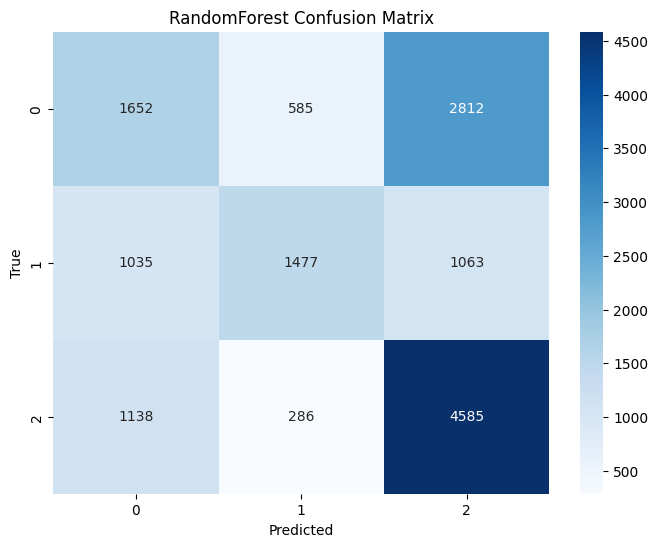

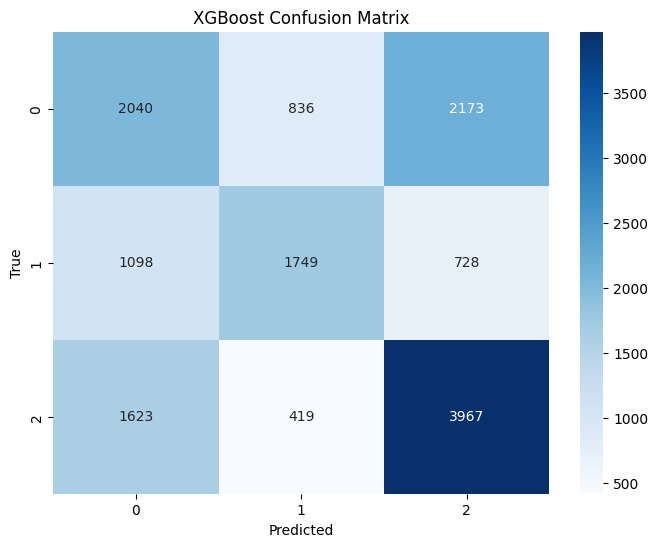

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_test, rf_predictions, 'RandomForest Confusion Matrix')

plot_confusion_matrix(y_test, xgb_predictions, 'XGBoost Confusion Matrix')

Ключевые слова для классификаторов

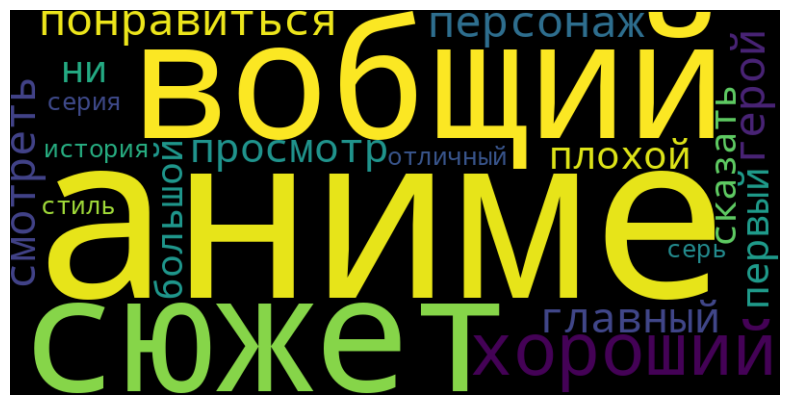

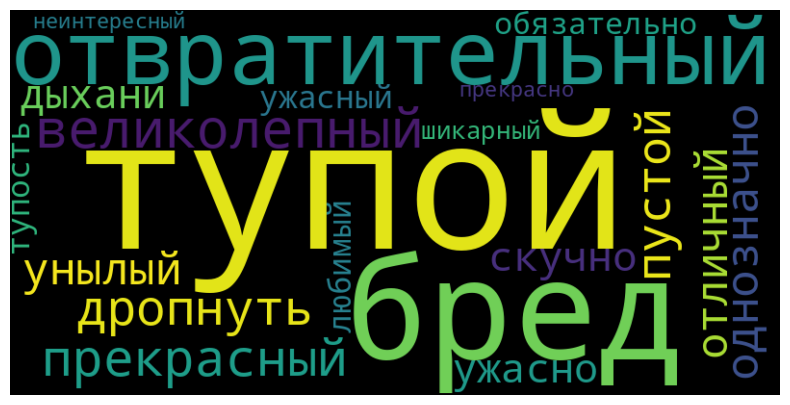

In [ ]:
def plot_wordcloud(model, vectorizer, n_top_words=20):
    feature_names = vectorizer.get_feature_names_out()
    importances = model.feature_importances_
    indices = np.argsort(importances)[-n_top_words:]
    words = [feature_names[i] for i in indices]
    weights = importances[indices]

    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(dict(zip(words, weights)))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

plot_wordcloud(rf_model, vectorizer)

plot_wordcloud(xgb_model, vectorizer)

Отрисовать рисунки обученных деревьев из случайного леса и бустинга с указанием текста влияющего на ветвление дерева


In [ ]:
from sklearn.tree import export_graphviz
import graphviz
from xgboost import XGBClassifier, plot_tree

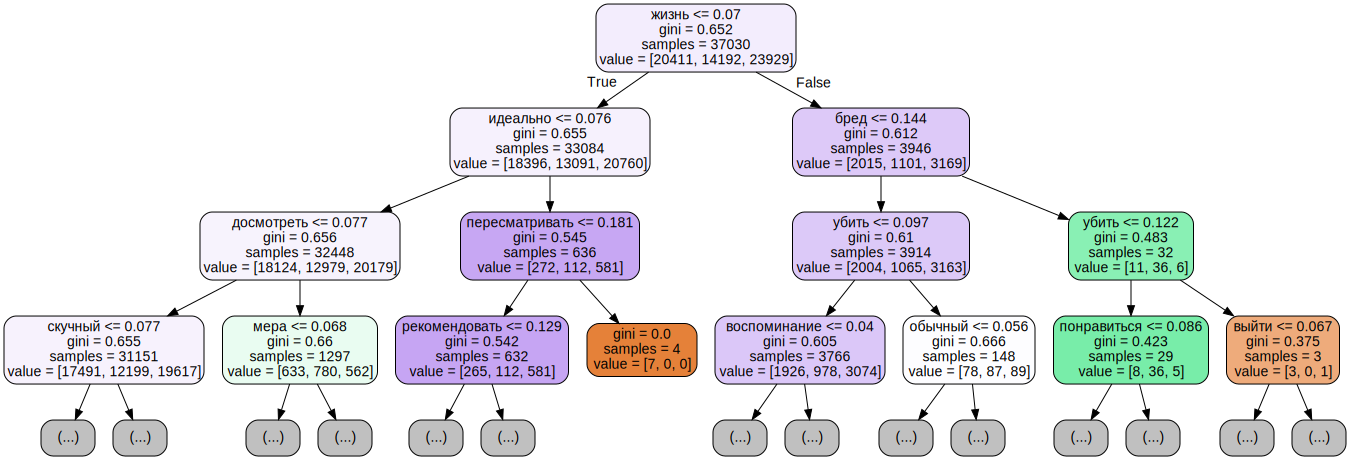

In [32]:
from sklearn.tree import export_graphviz
import graphviz

# визуализация одного дерева RF
tree = rf_model.estimators_[0]

dot_data = export_graphviz(tree, feature_names=vectorizer.get_feature_names_out(),
                           filled=True, rounded=True, max_depth=3)  # max_depth=3 для визуализации только верхних уровней дерева
graph = graphviz.Source(dot_data)
graph.render("random_forest_tree_limited_depth", format='png')
graph

<Figure size 2000x1000 with 0 Axes>

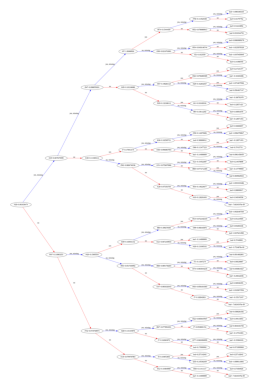

In [37]:
# визуализация одного дерева XGBoost
def visualize_xgboost_tree(xgb_model, num_tree=0, rankdir='LR'):
    plt.figure(figsize=(20, 10))
    plot_tree(xgb_model, num_trees=num_tree, rankdir=rankdir)
    plt.savefig(f'xgboost_tree_{num_tree}.png')
    plt.show()

visualize_xgboost_tree(xgb_model, num_tree=0)